# Project done by: Mario Perez, Julian Subagiyo & Benjamin Jacobsen

# References


In the proces of building this notebook the project group has used the follow as help and references:



*   Notebooks provided in class
*   Deep Learning Essentials course on: https://www.bluecourses.com
*   Part 2 datasource:
    https://www.kaggle.com/datasets/samfaraday/daily-minimum-temperatures-in-me
*   Chatgpt.com






# Library import

In [1]:
%tensorflow_version 2.x

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import os
import tensorflow as tf
from sklearn.preprocessing import *
from sklearn.metrics import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.regularizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from sklearn.model_selection import *
import shap
from scipy.ndimage import zoom


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Data Import

In [2]:
# DATA LOADING
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [3]:
#Reading training dataset

train_df = pd.read_csv('train_image_class.csv')
train_df['Image Path'] = train_df['Image Path'].apply(lambda x: os.path.join("", x))

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='Image Path',  #DataFrame column name
    y_col='Label',       #DataFrame column name
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    color_mode="grayscale" #make sure the same in train and test
)

Found 6114 validated image filenames belonging to 5 classes.


In [4]:
#Reading test dataset

val_df = pd.read_csv('valid_image_class.csv')
val_df['Image Path'] = val_df['Image Path'].apply(lambda x: os.path.join("", x))

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='Image Path',  #DataFrame column name
    y_col='Label',       #DataFrame column name
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    color_mode="grayscale" #make sure here this is in color
)

Found 1529 validated image filenames belonging to 5 classes.


In [5]:
num_classes = 5

In [6]:
# Label and corresponding number

class_indices = train_generator.class_indices
class_indices_val = val_generator.class_indices

print(class_indices)
print(class_indices_val)

{'animals': 0, 'objects': 1, 'others': 2, 'people': 3, 'scenes': 4}
{'animals': 0, 'objects': 1, 'others': 2, 'people': 3, 'scenes': 4}


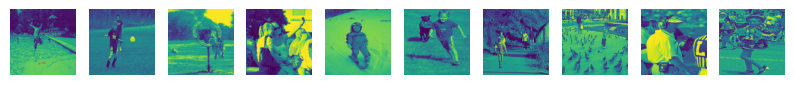

In [7]:
import matplotlib.pyplot as plt

# Fetch one batch
images, labels = next(val_generator)

# Plot first 10 images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(images[i])
    plt.axis("off")
plt.show()

# Part 1


# STEP 1: First MLP

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(256, 256, 1)))  # Flatten image into 1D vector

model.add(Dense(512, activation='sigmoid'))  # First hidden layer
model.add(Dropout(0.3))  # Regularization

model.add(Dense(256, activation='sigmoid'))  # Second hidden layer
model.add(Dropout(0.3))

model.add(Dense(128, activation='sigmoid'))  # Third hidden layer

model.add(Dense(num_classes, activation='softmax'))  # Output layer

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      33,554,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,719,813 (128.63 MB)

 Trainable params: 33,719,813 (128.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


383/383 ━━━━━━━━━━━━━━━━━━━━ 37s 84ms/step - accuracy: 0.5368 - loss: 1.1989 - val_accuracy: 0.5337 - val_loss: 1.2518
Epoch 2/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 36s 77ms/step - accuracy: 0.5370 - loss: 1.1804 - val_accuracy: 0.5337 - val_loss: 1.1900
Epoch 3/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.5465 - loss: 1.1765 - val_accuracy: 0.5337 - val_loss: 1.1768
Epoch 4/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 29s 77ms/step - accuracy: 0.5558 - loss: 1.1593 - val_accuracy: 0.5337 - val_loss: 1.1789
Epoch 5/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - accuracy: 0.5474 - loss: 1.1859 - val_accuracy: 0.5337 - val_loss: 1.1886
Epoch 6/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 30s 78ms/step - accuracy: 0.5437 - loss: 1.1702 - val_accuracy: 0.5337 - val_loss: 1.1784
Epoch 7/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.5541 - loss: 1.1552 - val_accuracy: 0.5337 - val_loss: 1.1834
Epoch 8/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - accuracy: 0.5507 - loss: 1.1569 - val_accurac

# Results

The model slightly increases in accuracy of the training data, but is stagnant in the valdation accuracy over all the epochs. These results indicate that the model is not generalizing well. The reason for this could be the use of the sigmoid function, where gradients vanish, limited model depth or not using convolutional layers.

# STEP 1: Second MLP

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(256, 256, 1)))  # Flatten image into 1D vector

model.add(Dense(1024, activation='relu'))  # More neurons
model.add(Dropout(0.4))  # Increased dropout

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  # Output layer

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │      67,109,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,767,301 (258.51 MB)

 Trainable params: 67,767,301 (258.51 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

Epoch 1/5
383/383 ━━━━━━━━━━━━━━━━━━━━ 36s 86ms/step - accuracy: 0.4214 - loss: 12.8604 - val_accuracy: 0.5330 - val_loss: 1.1955
Epoch 2/5
383/383 ━━━━━━━━━━━━━━━━━━━━ 29s 76ms/step - accuracy: 0.5380 - loss: 1.1787 - val_accuracy: 0.5337 - val_loss: 1.1754
Epoch 3/5
383/383 ━━━━━━━━━━━━━━━━━━━━ 29s 76ms/step - accuracy: 0.5412 - loss: 1.1710 - val_accuracy: 0.5337 - val_loss: 1.1768
Epoch 4/5
383/383 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.5462 - loss: 1.1703 - val_accuracy: 0.5278 - val_loss: 1.1842
Epoch 5/5
383/383 ━━━━━━━━━━━━━━━━━━━━ 40s 76ms/step - accuracy: 0.5425 - loss: 1.1696 - val_accuracy: 0.5337 - val_loss: 1.1760


# Results
We tried updating the MLP and remove the overfitting by adding more layers, use ReLU activations and increase dropout, yet the validation accuracy remains around 0.5337. Despite a big drop in the training loss after the first epoch, the performance on the validation data does not improve, again indicating the is bad at generalizing. This is possible still due to not using convolutional layers.

# STEP 2: CNN APPENDIX

In [ ]:
model = Sequential()
model.add(Conv2D(32, (2, 2), padding='valid', input_shape=(256, 256, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4), strides=2))
model.add(Conv2D(64, (3, 3), padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=1))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 255, 255, 32)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 126, 126, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 125, 125, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1000000)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │      64,000,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,019,045 (244.21 MB)

 Trainable params: 64,019,045 (244.21 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=2        # low epoch to avoid overfitting
)

Epoch 1/2
192/192 ━━━━━━━━━━━━━━━━━━━━ 43s 187ms/step - accuracy: 0.4414 - loss: 7.3229 - val_accuracy: 0.5468 - val_loss: 1.1958
Epoch 2/2
192/192 ━━━━━━━━━━━━━━━━━━━━ 30s 154ms/step - accuracy: 0.6078 - loss: 1.0184 - val_accuracy: 0.4330 - val_loss: 1.2994


Observations of the model:
high accuracy when training by epoch 6, but poor validation accuracy 0.53, additionally validations keeps increasing, also 100% accuracy means overfitting

In [ ]:
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 34s 166ms/step - accuracy: 0.6784 - loss: 0.8003 - val_accuracy: 0.5337 - val_loss: 1.1733
Epoch 2/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 30s 159ms/step - accuracy: 0.7361 - loss: 0.7042 - val_accuracy: 0.5592 - val_loss: 1.1687
Epoch 3/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 31s 160ms/step - accuracy: 0.7793 - loss: 0.6031 - val_accuracy: 0.5448 - val_loss: 1.2336
Epoch 4/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 30s 154ms/step - accuracy: 0.8249 - loss: 0.5166 - val_accuracy: 0.5350 - val_loss: 1.2565
Epoch 5/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 30s 154ms/step - accuracy: 0.8799 - loss: 0.4092 - val_accuracy: 0.5370 - val_loss: 1.3468
Epoch 6/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 31s 163ms/step - accuracy: 0.9236 - loss: 0.2992 - val_accuracy: 0.5383 - val_loss: 1.5381
Epoch 7/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 31s 160ms/step - accuracy: 0.9587 - loss: 0.2199 - val_accuracy: 0.5428 - val_loss: 1.5890
Epoch 8/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 31s 160ms/step - accuracy: 0.9776 - loss: 0

OBSERVATIONS

With a higher epoch we can observe overfitting.

what can we try?

use a dropout to reduce the learning from the training

# STEP 3: EXPERIMENTS

# Experiment 1

Now that we trained a CNN with the information from the appendix, we wil try to improve the performance.

In [8]:
#First experiment

model = Sequential()
model.add(Conv2D(32, (2, 2), padding='valid', input_shape=(256, 256, 1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(4, 4), strides=1))
model.add(Dropout(0.3))

#second convolutional layer
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=1))
model.add(Dropout(0.3))
#Third convolutional layer (even more deep network)
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=1))
model.add(Dropout(0.3))

#flattening
model.add(Flatten())

#Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

#Now compile
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 255, 255, 32)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 255, 255, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 252, 252, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 252, 252, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 252, 252, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 252, 252, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 251, 251, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 251, 251, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 251, 251, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 251, 251, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 250, 250, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 250, 250, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8000000)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │   1,024,000,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,024,094,181 (3.82 GB)

 Trainable params: 1,024,093,733 (3.82 GB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-9-7e2d9ae60f57>", line 1, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

Out of memory while trying to allocate 4112777216 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_3625]

We see now that a high number of epochs does not lead to an overfitting issue of the training accuracy being high due to the inclusion of a dropout layer. We also decreased the strides argument to 1 and included Batch Normalization and added one more convolutional Layer in hopes for higher performance measures.

# EXPERIMENT 2

In [10]:
# Define a deeper CNN
model = Sequential()

# First Conv Layer
model.add(Conv2D(64, (3, 3), padding='valid', input_shape=(256, 256, 1), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second Conv Layer
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Third Conv Layer
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Flattening
model.add(Flatten())


# Fully Connected Layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))

In [11]:
# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 254, 254, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 254, 254, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 254, 254, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 254, 254, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 254, 254, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 254, 254, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 254, 254, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 438,533 (1.67 MB)

 Trainable params: 437,637 (1.67 MB)

 Non-trainable params: 896 (3.50 KB)

In [12]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


Epoch 1/10


RuntimeError: pybind11::error_already_set: MISMATCH of original and normalized active exception types: ORIGINAL ResourceExhaustedError REPLACED BY KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/errors_impl.py(377): __init__
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/execute.py(53): quick_execute
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/context.py(1683): call_function
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py(251): call_flat
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py(216): call_preflattened
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/concrete_function.py(1322): _call_flat
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py(919): _call
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py(833): __call__
  /usr/local/lib/python3.11/dist-packages/tensorflow/python/util/traceback_utils.py(150): error_handler
  /usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py(219): function
  /usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py(371): fit
  /usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py(117): error_handler
  <ipython-input-12-5f1de85b6140>(1): <cell line: 0>
  /usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py(3553): run_code
  /usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py(3473): run_ast_nodes
  /usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py(3257): run_cell_async
  /usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py(78): _pseudo_sync_runner
  /usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py(3030): _run_cell
  /usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py(2975): run_cell
  /usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py(528): run_cell
  /usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py(383): do_execute
  /usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py(730): execute_request
  /usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py(406): dispatch_shell
  /usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py(499): process_one
  /usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py(510): dispatch_queue
  /usr/lib/python3.11/asyncio/events.py(84): _run
  /usr/lib/python3.11/asyncio/base_events.py(1936): _run_once
  /usr/lib/python3.11/asyncio/base_events.py(608): run_forever
  /usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py(205): start
  /usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py(712): start
  /usr/local/lib/python3.11/dist-packages/traitlets/config/application.py(992): launch_instance
  /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py(37): <module>
  <frozen runpy>(88): _run_code
  <frozen runpy>(198): _run_module_as_main


In this we tried Global Average Pooling instead of a Pooling layer after every Convolutional layer and increased the neurons in every convolutional layer. (Best Practices Video)

# EXPERIMENT 3


In [ ]:
#Now here we are defining a deeper CNN

# Define a deeper CNN
model = Sequential()

# First Conv Layer
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='valid', input_shape=(256, 256, 1), activation='relu'))
model.add(Dropout(0.3))

# Second Conv Layer
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Dropout(0.3))

# Third Conv Layer
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))

# Flattening
model.add(Flatten())


# Fully Connected Layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))

In [ ]:
# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_3                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ ?                           │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 185s 460ms/step - accuracy: 0.5538 - loss: 1.1932 - val_accuracy: 0.3839 - val_loss: 1.2336
Epoch 2/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 171s 447ms/step - accuracy: 0.5507 - loss: 1.1438 - val_accuracy: 0.5206 - val_loss: 1.1633
Epoch 3/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 178s 464ms/step - accuracy: 0.5598 - loss: 1.1427 - val_accuracy: 0.5605 - val_loss: 1.1560
Epoch 4/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 171s 447ms/step - accuracy: 0.5748 - loss: 1.0947 - val_accuracy: 0.5605 - val_loss: 1.1409
Epoch 5/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 202s 447ms/step - accuracy: 0.5729 - loss: 1.1187 - val_accuracy: 0.5330 - val_loss: 1.1625
Epoch 6/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 171s 446ms/step - accuracy: 0.5793 - loss: 1.1056 - val_accuracy: 0.5507 - val_loss: 1.1335
Epoch 7/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 209s 464ms/step - accuracy: 0.5690 - loss: 1.1006 - val_accuracy: 0.5239 - val_loss: 1.1620
Epoch 8/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 195s 446ms/step - accuracy: 0.5767 -

Lastly, we will try to change the order of the batch normalization layer, putting it in front of the non-linear activation layer which might help performance (Batch Normalization Video)

b) We will now advance with our best performing model and try to feed the model with more augmented data

In [30]:
#the agumentation is only applied to the training set

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)

#Training set
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="Image Path",
    y_col="Label",
    target_size=(256, 256),
    batch_size=16,
    class_mode="categorical",
    color_mode="grayscale"
)

#Validation set
val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col="Image Path",
    y_col="Label",
    target_size=(256, 256),
    batch_size=16,
    class_mode="categorical",
    color_mode="grayscale"
)

Found 6114 validated image filenames belonging to 5 classes.
Found 1529 validated image filenames belonging to 5 classes.


In [ ]:
#########
##BEST PERFORMING MODEL##
#########

In [31]:
# Experiment 2 model
model = Sequential()

# First Conv Layer
model.add(Conv2D(64, (3, 3), padding='valid', input_shape=(256, 256, 1), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second Conv Layer
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Third Conv Layer
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Flattening
model.add(Flatten())


# Fully Connected Layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 254, 254, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 254, 254, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 254, 254, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 254, 254, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 254, 254, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 254, 254, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 254, 254, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 438,533 (1.67 MB)

 Trainable params: 437,637 (1.67 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 242s 536ms/step - accuracy: 0.4400 - loss: 1.4739 - val_accuracy: 0.4984 - val_loss: 1.3625
Epoch 2/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 185s 483ms/step - accuracy: 0.4984 - loss: 1.3277 - val_accuracy: 0.5461 - val_loss: 1.2561
Epoch 3/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 185s 482ms/step - accuracy: 0.5232 - loss: 1.2787 - val_accuracy: 0.5683 - val_loss: 1.2365
Epoch 4/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 184s 481ms/step - accuracy: 0.5160 - loss: 1.2620 - val_accuracy: 0.5651 - val_loss: 1.3187
Epoch 5/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 184s 481ms/step - accuracy: 0.5456 - loss: 1.2050 - val_accuracy: 0.5278 - val_loss: 1.2057
Epoch 6/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 184s 480ms/step - accuracy: 0.5505 - loss: 1.2030 - val_accuracy: 0.5755 - val_loss: 1.1635
Epoch 7/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 184s 479ms/step - accuracy: 0.5349 - loss: 1.2342 - val_accuracy: 0.5245 - val_loss: 1.1709
Epoch 8/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 183s 478ms/step - accuracy: 0.5458 -

Data Augmentation did not hugely benefit the model performance.

# C: Data Interpretation Techniques

In [ ]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 254, 254, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 254, 254, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 254, 254, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 254, 254, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 254, 254, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 438,533 (1.67 MB)

 Trainable params: 437,637 (1.67 MB)

 Non-trainable params: 896 (3.50 KB)

# SHAP


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


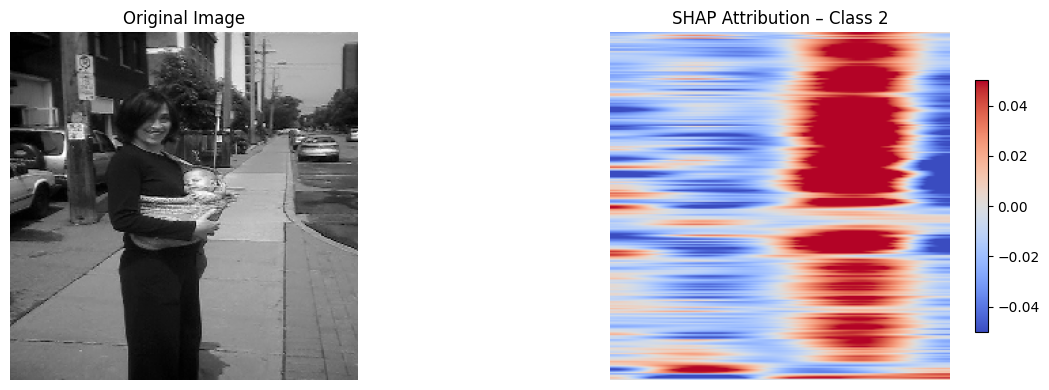

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


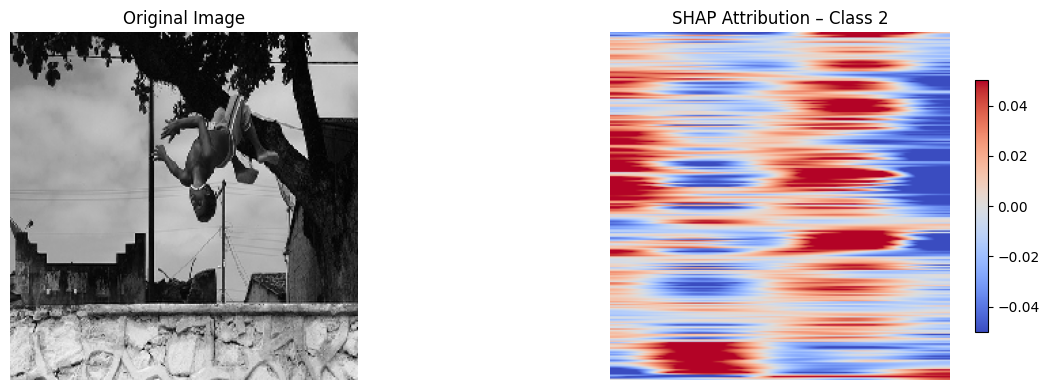

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


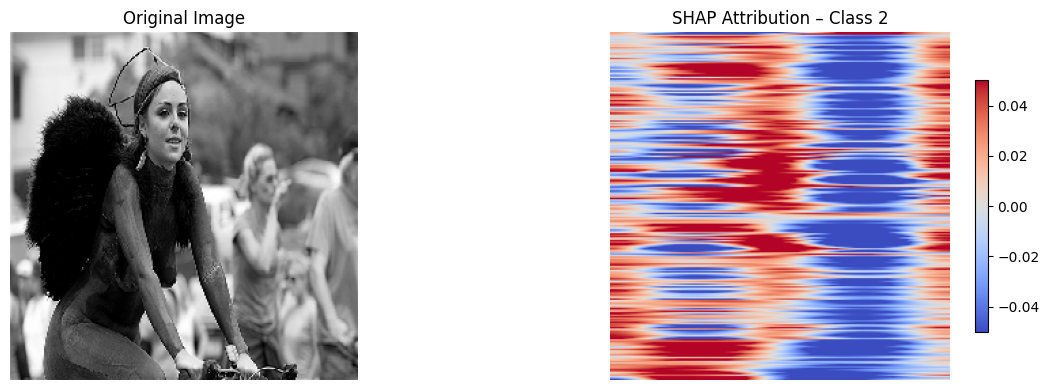

In [ ]:
X_batch, y_batch = next(val_generator)

n_samples = min(10, X_batch.shape[0])
background = X_batch[:n_samples]
random_indices = np.random.choice(range(n_samples, len(X_batch)), 3, replace=False)
test_images = X_batch[random_indices]
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(test_images)

for i in range(len(test_images)):
    plt.figure(figsize=(12, 4))

    prediction = model.predict(test_images[i:i+1])[0]
    predicted_class = np.argmax(prediction)

    # Clearer visual - No colors if this is not done
    shap_map = shap_values[predicted_class][i].squeeze() * 1e6
    shap_map_zoomed = zoom(shap_map, (1, 50))

    # Plot image
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].squeeze(), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Plot heatmap
    plt.subplot(1, 2, 2)
    img = plt.imshow(shap_map_zoomed, cmap='coolwarm', vmin=-0.05, vmax=0.05, interpolation='bilinear')
    plt.title(f"SHAP Attribution – Class {predicted_class}")
    plt.axis('off')

    # plot colorbar
    plt.colorbar(img, fraction=0.02, pad=0.04)

    plt.tight_layout()
    plt.show()

In [ ]:
# Reason for bad color performance, without scaled results, are very low shap values, almost 0

print(np.min(shap_values[0]), np.max(shap_values[0]))

Based on these SHAP visuals, it is clear that the model performs poorly at focusing on the relevant objects in the image. It is overly sensitive to noise, causing predictions to be influenced by irrelevant areas rather than meaningful features.

# Occlusion Sensitivity

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

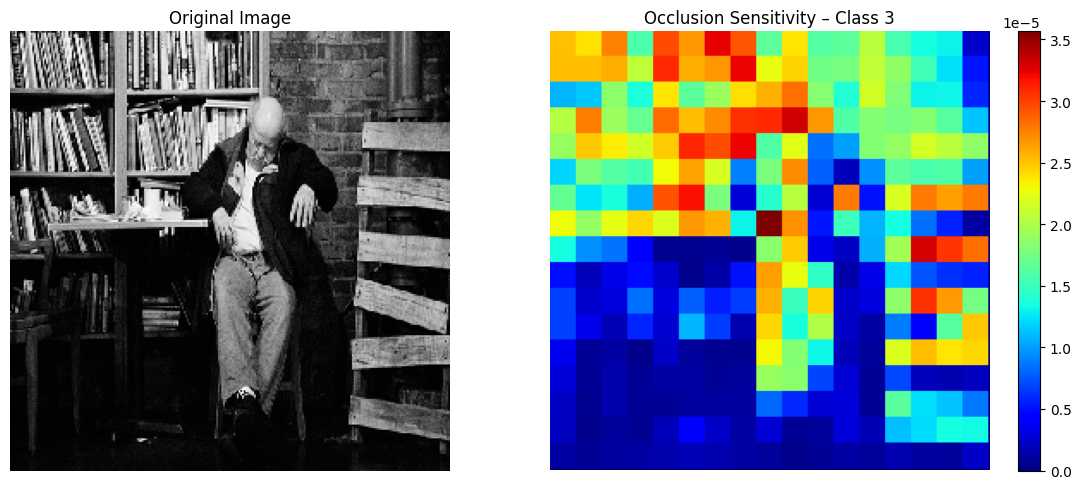

In [35]:
def occlusion_map(model, img, label_index, patch_size=15):
    """
    Generates an occlusion sensitivity heatmap for a single image.
    """
    height, width, channels = img.shape
    heatmap = np.zeros((height, width))
    base_pred = model.predict(img[np.newaxis, ...])[0, label_index]

    for i in range(0, height - patch_size, patch_size):
        for j in range(0, width - patch_size, patch_size):
            occluded_img = img.copy()
            occluded_img[i:i+patch_size, j:j+patch_size, :] = 0
            occluded_pred = model.predict(occluded_img[np.newaxis, ...])[0, label_index]
            heatmap[i:i+patch_size, j:j+patch_size] = base_pred - occluded_pred

    return heatmap

# One batch from validation generator
X_batch, y_batch = next(val_generator)

# One test image and its predicted class
sample_img = X_batch[0]
predicted_class = np.argmax(model.predict(sample_img[np.newaxis, ...])[0])

# occlusion heatmap
heatmap = occlusion_map(model, sample_img, predicted_class, patch_size=15)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='jet')
plt.title(f"Occlusion Sensitivity – Class {predicted_class}")
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()


In [38]:
# Low value shows the model weak certainty of the prediction

pred = model.predict(sample_img[np.newaxis, ...])[0]
print(f"Prediction confidence for class {predicted_class}: {pred[predicted_class]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction confidence for class 3: 0.2041


This occlusion sensitivity map further highlights the model's poor performance. Despite making a correct prediction, the model focuses on irrelevant regions, suggesting that its success is more coincidental than reliable.

## D) Transfer Learning

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Create new input layer for grayscale
new_input = Input(shape=(256, 256, 1))
new_conv = Conv2D(3, (1, 1), padding="same")(new_input)  # Convert 1 channel to 3

# Feature Extraction
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(5, activation='softmax', name='predictions')(x)

# Connect to original model
modified_model = Model(inputs=new_input, outputs=base_model(new_conv))

# Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 254, 254, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 254, 254, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 254, 254, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 254, 254, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 254, 254, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 438,533 (1.67 MB)

 Trainable params: 437,637 (1.67 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 213s 481ms/step - accuracy: 0.5484 - loss: 1.1650 - val_accuracy: 0.5801 - val_loss: 1.1161
Epoch 2/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 182s 474ms/step - accuracy: 0.5503 - loss: 1.1600 - val_accuracy: 0.5670 - val_loss: 1.1566
Epoch 3/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 183s 477ms/step - accuracy: 0.5562 - loss: 1.1527 - val_accuracy: 0.5670 - val_loss: 1.1200
Epoch 4/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 199s 469ms/step - accuracy: 0.5641 - loss: 1.1595 - val_accuracy: 0.5670 - val_loss: 1.1201
Epoch 5/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 188s 490ms/step - accuracy: 0.5632 - loss: 1.1330 - val_accuracy: 0.5121 - val_loss: 1.1757
Epoch 6/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 181s 472ms/step - accuracy: 0.5580 - loss: 1.1407 - val_accuracy: 0.5644 - val_loss: 1.1204
Epoch 7/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 188s 491ms/step - accuracy: 0.5594 - loss: 1.1144 - val_accuracy: 0.5729 - val_loss: 1.0987
Epoch 8/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 186s 487ms/step - accuracy: 0.5789 -

# e) Part 1 Conclusion

We saw in our MLP models that we don't achieve an accuracy above 0.5337 for these we tried to increase the complexity of the model by increasing the number of hidden layers.

For the CNNs we first implemented the model of the Appendix in which we achieved a decent accuracy of 0.5592 but with the cost of overfitting as we observed a training accuracy of up to 0.9931.
In the first experiment we added another convolutional layer, we changed activation functions to all ReLu. To avoid the issues of overfitting we took upon the steps of including a three dropout layers after every convoultional layer. Also, BatchNormalization was applied, strides were reduced to 1 instead of 2 and the learning rate was decreased.*

In the second experiment which was the best performing one we replaced the MaxPooling layers with one GlobalPooling layer and we doubled the nodes in the convolutional layers. (Validation Performance: 0.57)

Lastly, we tried tweaking this model a little bit further on by swapping the order of BatchNormalization. but this step did not improve our models performance.

We then tried using transfer learning, where we loaded the ResNet50 model, which is pre-trained on over 1 million images and consists of 50 layers. Despite its higher complexity, the transfer learning model slightly outperformed our original model. The ResNet50-based model achieved a maximum validation accuracy of 0.5925, compared to the original model’s peak of 0.575. This improvement, though it is not much, gives a small demonstration of the effectiveness of transfer learning in leveraging pre-trained features for improved performance.

# PART 2

In [ ]:
#PART 2 - EXPLORING RNNS & CNNS FOR A SEQUENCE PREDICTION TASK
#RNN is not possible because it is widely used for designed  sequential data, whereas our dataset is primarily image-based with static classifications.
#Our dataset does not have a time-dependent or sequential structure, which is the main point of using RNN.

#In this case we will apply a new dataset


In [ ]:
# Read the CSV file
df = pd.read_csv("/content/daily_temperature.csv")

# Inspection
daily_temperature.head()



,Date,"Daily minimum temperatures in Melbourne, Australia, 1981-1990"
0,1/1/1981,20.7
1,1/2/1981,17.9
2,1/3/1981,18.8
3,1/4/1981,14.6
4,1/5/1981,15.8


Data pre processing

In [ ]:
  # Convert Date column to datetime

df['Date'] = pd.to_datetime(df['Date']) #This step is important because timeseries works with movements or sequence of events during times
df.set_index('Date', inplace=True)


In [ ]:
df.columns = ['Temperature']

df.head()

,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [ ]:
# Convert to numerics and convert errors to NA
df['Temperature'] = pd.to_numeric(df['Temperature'], errors='coerce')

# Drop NaN values
df.dropna(inplace=True)

# Normalize the cleaned data
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = scaler.fit_transform(df[['Temperature']])


In [ ]:
# Create sequences -> why a sequence??... we are essentially transforming our dataset into a format that the model can use to recognize trends over time.
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(df_scaled, seq_length)

What I did here is I created a sequence where X contains previous values and y the target or prediction, looping through all the past data and input them in the X;

Why we need sequences? LSTM learns from temporal patterns

In [ ]:
#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


In [ ]:
#Now we train the simple RNN model using a single LSTM

model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, activation='relu'),
    Dense(25),
    Dense(1)
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0373 - val_loss: 0.0100
Epoch 2/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0118 - val_loss: 0.0101
Epoch 3/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0117 - val_loss: 0.0099
Epoch 4/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0117 - val_loss: 0.0095
Epoch 5/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0119 - val_loss: 0.0090
Epoch 6/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0101 - val_loss: 0.0087
Epoch 7/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0101 - val_loss: 0.0075
Epoch 8/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0098 - val_loss: 0.0072
Epoch 9/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0094 - val_loss: 0.0072
Epoch 10/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0096 - val_loss: 0.0075
Epoch 11/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0088 - val_loss: 0.0078
Epoch 12/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


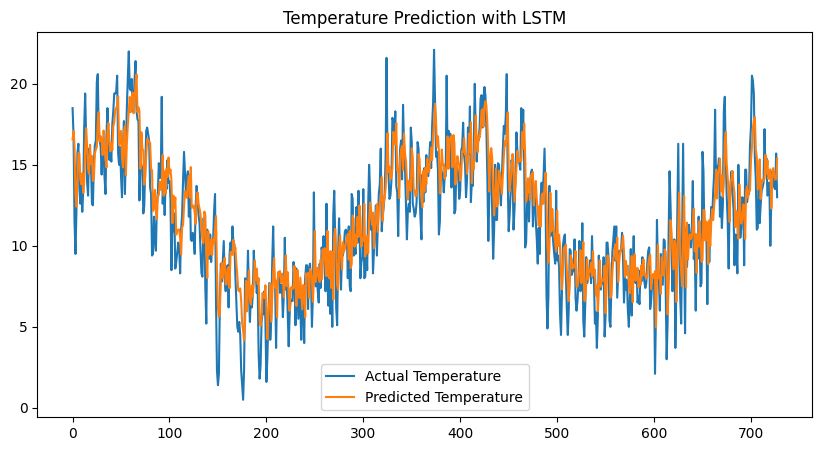

In [ ]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Actual Temperature",
         color='royalblue', linewidth=1.5)
plt.plot(y_pred_inv, label="Predicted Temperature",
         color='crimson', linestyle='--', linewidth=1.5)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.title("Actual vs Predicted Temperature\nLSTM Model Performance", fontsize=14)
plt.legend(fontsize=11, framealpha=1)
plt.grid(True, linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()

This graph shows a comparison between the actual temperatures and the predicted temperatures using a simple LSTM model

As a conclusion ->a time series prediction of temperature using an LSTM model. The actual and predicted temperatures are closely aligned, which is a good sign.

In [ ]:

r2 = r2_score(y_test_inv, y_pred_inv)
print(r2) #we are using R squared as a metric of fit means your LSTM model explains about 70% of the variance in the temperature data. This is a decent result, there is still room for improvement LETS PLAY WITH IT!!

0.7026884679368977


In [ ]:
mse = mean_squared_error(y_test_inv, y_pred_inv)
print(mse)

In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = scaler.fit_transform(df[['Temperature']])

# Create sequences
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(df_scaled, seq_length)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Define GRU model
model = Sequential([
    GRU(64, activation='tanh', return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    GRU(64, activation='tanh', return_sequences=True),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)
# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('GRU Model Training Performance')
plt.show()

The blue line decreases which means the model is learning patterns in the training, while the orangeline dicreases but shows some changes probably overfitting

Conclusions until this step-> The model is learning effectively without major overfitting

Minimal fluctuations in validation loss: Model generalizes well.



In [ ]:
# Make predictions
y_pred = model.predict(X_test)

y_pred = y_pred[:, -1, 0]
y_test = y_test.reshape(-1)

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.title('Actual vs Predicted Temperatures using GRU')
plt.show()

The predicted values (red) closely follow the actual temperature patterns (blue).

In [ ]:
y_pred.shape

In [ ]:
y_pred = model.predict(X_test)
y_pred = y_pred[:, -1, :]
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

In [ ]:
mse = mean_squared_error(y_test_inv, y_pred_inv)

print(mse)

Now we will add attention to the ** BEST PERFORMING MODEL **
The best performing model based on loss is the GRU because it gives far more precise predictions in terms of squared error.

In [ ]:
#Define the first steps
seq_length = 10
input_dim = 1

inputs = Input(shape=(seq_length, input_dim))

#GRU layers
gru_out1 = GRU(64, return_sequences=True)(inputs)
drop1 = Dropout(0.2)(gru_out1)

gru_out2 = GRU(64, return_sequences=True)(drop1)
drop2 = Dropout(0.2)(gru_out2)


#Here we apply the attention
attention = Attention()([drop2, drop2])
context_vector = Concatenate()([drop2, attention])

# Output layers
dense1 = Dense(32, activation='relu')(context_vector)
output = Dense(1)(dense1)

In [ ]:

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=16,
                    validation_data=(X_test, y_test))

In [ ]:
# Predict
y_pred = model.predict(X_test)  # shape is (728, 10, 1)

# Keep only the last timestep
y_pred_last = y_pred[:, -1]     # shape becomes (728,)

# Reshape to 2D (728, 1) for inverse transform
y_pred_last = y_pred_last.reshape(-1, 1)

# Inverse transform
y_pred_inv = scaler.inverse_transform(y_pred_last)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print("MSE:", mse)
print("R2 Score:", r2)


In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = scaler.fit_transform(df[['Temperature']])

# Create sequences
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(df_scaled, seq_length)


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Reshape for CNN input (adding channel dimension)
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Define CNN model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1)
])


In [ ]:
# Compile the CNN model
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Train the CNN model
cnn_history = cnn_model.fit(X_train_cnn, y_train, epochs=50, batch_size=16, validation_data=(X_test_cnn, y_test), verbose=1)

In [ ]:
# Plot CNN training history
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('CNN Model Training Performance')
plt.show()

In [ ]:
# Evaluate the CNN model
y_pred = cnn_model.predict(X_test_cnn)

y_pred = y_pred.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)

y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test_reshaped)

mse = mean_squared_error(y_test_inv, y_pred_inv)

In [ ]:
print(mse)

Why the MSE is lower (which means better) in GRU with attention than in CNN
First lets explain what is gru-> it captures patterns over many steps + attention it captures key signals in the sequence

Also, CNN has limitations in time series because they LACK memory and they do not model temporal dependencies like GRU

GRU learns from order, while CNN just convolve fixed paterns